In [1]:
import sqlite3

connection = sqlite3.connect('student.grades.db')
cursor = connection.cursor()

In [2]:
cursor.execute('DROP TABLE IF EXISTS students')
cursor.execute('DROP TABLE IF EXISTS grades')

In [3]:
cursor.execute('''
CREATE TABLE IF NOT EXISTS students (
    student_id INTEGER PRIMARY KEY AUTOINCREMENT,
    first_name TEXT,
    last_name TEXT
)
''');

cursor.execute('''
CREATE TABLE IF NOT EXISTS grades (
    grade_id INTEGER PRIMARY KEY AUTOINCREMENT,
    student_id INTEGER,
    subject TEXT,
    grade INTEGER,
    FOREIGN KEY (student_id) REFERENCES students(student_id)
)
''');

In [4]:
student_data = [
    ('John', 'Smith'),
    ('Lily', 'Jones'),
    ('Paul', 'Brown'),
    ('Sydney', 'Marks'),
    ('Mary', 'Truman')
]

cursor.executemany('''
INSERT INTO students (first_name, last_name) VALUES (?, ?)
''', student_data)

connection.commit()

In [5]:
grades_data = [
    ('1', 'Math', '95'),
    ('1', 'English', '92'),
    ('1', 'Science', '98'),
    ('2', 'Math', '80'),
    ('2', 'English', '90'),
    ('2', 'Science', '95'),
    ('3', 'Math', '93'),
    ('3', 'English', '91'),
    ('3', 'Science', '94'),
    ('4', 'Math', '88'),
    ('4', 'English', '82'),
    ('4', 'Science', '90'),
    ('5', 'Math', '80'),
    ('5', 'English', '93'),
    ('5', 'Science', '89')
]

cursor.executemany('''
INSERT INTO grades (student_id, subject, grade) VALUES (?, ?, ?)
''', grades_data)

connection.commit()

In [6]:
cursor.execute('''
SELECT students.first_name, students.last_name, grades.grade
FROM students
JOIN grades ON students.student_id = grades.student_id
''')

joined_data = cursor.fetchall()
print("Joined students and grades:")
for row in joined_data:
    print(f"{row[0]} {row[1]}: {row[2]}")

Joined students and grades:
John Smith: 95
John Smith: 92
John Smith: 98
Lily Jones: 80
Lily Jones: 90
Lily Jones: 95
Paul Brown: 93
Paul Brown: 91
Paul Brown: 94
Sydney Marks: 88
Sydney Marks: 82
Sydney Marks: 90
Mary Truman: 80
Mary Truman: 93
Mary Truman: 89


In [7]:
cursor.execute('''
SELECT students.first_name, students.last_name, ROUND(AVG(grades.grade)) as avg_grade
FROM students
JOIN grades ON students.student_id = grades.student_id
GROUP by first_name, last_name
''')
average_grade = cursor.fetchall()
for row in average_grade:
    print(f"{row[0]} {row[1]}: {row[2]}")

John Smith: 95.0
Lily Jones: 88.0
Mary Truman: 87.0
Paul Brown: 93.0
Sydney Marks: 87.0


In [8]:
cursor.execute('''
SELECT first_name, last_name, ROUND(AVG(grade)) as avg_grade
FROM student_grades
GROUP by first_name, last_name
ORDER BY avg_grade DESC
''')

top_student = cursor.fetchone()
print("The student with the highest average grade is " f"{top_student[0]} {top_student[1]}: {top_student[2]}")

The student with the highest average grade is John Smith: 95.0


In [9]:
cursor.execute('''
SELECT ROUND(AVG(grade)) as avg_grade
FROM grades
WHERE subject = 'Math'
GROUP BY subject
''')

math_average = cursor.fetchone()
print("The average grade for Math is " f"{math_average}")

The average grade for Math is (87.0,)


In [10]:
cursor.execute('''
SELECT DISTINCT students.first_name, students.last_name, grades.grade FROM students
JOIN grades on students.student_id = grades.student_id
WHERE grade > 90
GROUP BY first_name, last_name
''')

A_students = cursor.fetchall()
print("Students who scored above 90 in any subject: ")
for row in A_students:
    print(f"{row[0]} {row[1]}")

Students who scored above 90 in any subject: 
John Smith
Lily Jones
Mary Truman
Paul Brown


In [11]:
import pandas as pd

# Read sqlite query results into a pandas DataFrame
df_students = pd.read_sql_query('SELECT * FROM students', connection)
df_grades = pd.read_sql_query('SELECT * FROM grades', connection)

# Verify that result of SQL query is stored in the dataframe
print(df_students.head())
print(df_grades.head())

   student_id first_name last_name
0           1       John     Smith
1           2       Lily     Jones
2           3       Paul     Brown
3           4     Sydney     Marks
4           5       Mary    Truman
   grade_id  student_id  subject  grade
0         1           1     Math     95
1         2           1  English     92
2         3           1  Science     98
3         4           2     Math     80
4         5           2  English     90


In [12]:
df_combined = pd.merge(df_grades, df_students, left_on='student_id', right_on='student_id')

print(df_combined)

    grade_id  student_id  subject  grade first_name last_name
0          1           1     Math     95       John     Smith
1          2           1  English     92       John     Smith
2          3           1  Science     98       John     Smith
3          4           2     Math     80       Lily     Jones
4          5           2  English     90       Lily     Jones
5          6           2  Science     95       Lily     Jones
6          7           3     Math     93       Paul     Brown
7          8           3  English     91       Paul     Brown
8          9           3  Science     94       Paul     Brown
9         10           4     Math     88     Sydney     Marks
10        11           4  English     82     Sydney     Marks
11        12           4  Science     90     Sydney     Marks
12        13           5     Math     80       Mary    Truman
13        14           5  English     93       Mary    Truman
14        15           5  Science     89       Mary    Truman


In [13]:
student_avg = '''
SELECT students.first_name || ' ' || students.last_name as student_name, ROUND(AVG(grades.grade)) as avg_grade
FROM students
JOIN grades ON students.student_id = grades.student_id
GROUP by first_name, last_name
'''

student_avg_df = pd.read_sql_query(student_avg, connection)

In [14]:
subject_avg = '''
SELECT subject, ROUND(AVG(grade)) as avg_grade
FROM grades
GROUP BY subject
'''

subject_avg_df = pd.read_sql_query(subject_avg, connection)

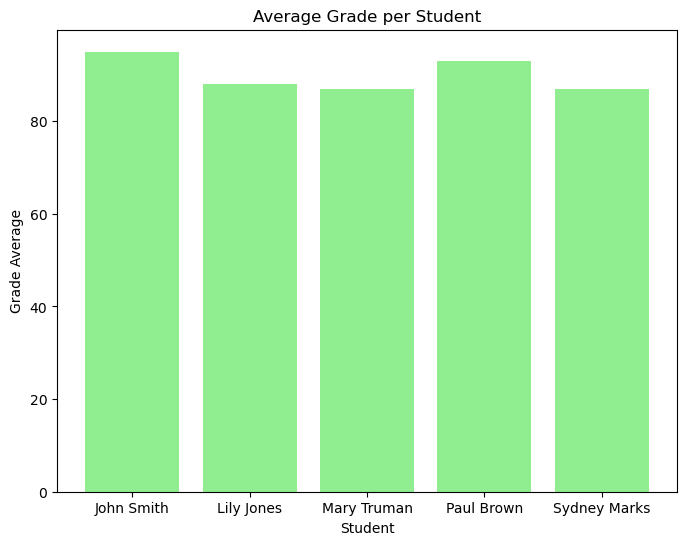

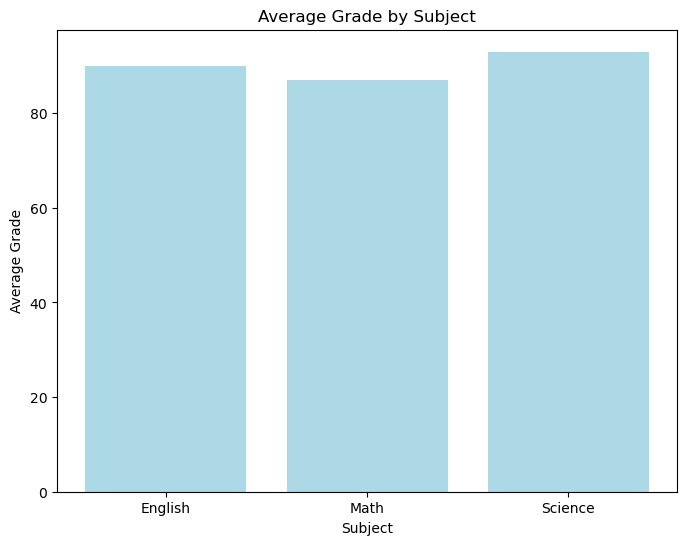

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.bar(student_avg_df['student_name'], student_avg_df['avg_grade'], color='lightgreen')
plt.xlabel('Student')
plt.ylabel('Grade Average')
plt.title('Average Grade per Student')
plt.show()

plt.figure(figsize=(8,6))
plt.bar(subject_avg_df['subject'], subject_avg_df['avg_grade'], color='lightblue')
plt.xlabel('Subject')
plt.ylabel('Average Grade')
plt.title('Average Grade by Subject')
plt.show()


In [17]:
cursor.close()
connection.close()